In [1]:
#!jt -t chesterish


Dorrit0, dorrit1, jelle0, night0, night1

In [15]:
data_path_old = r"C:\Users\Fin Amin\Desktop/\StemCellResearch\datasets_Sahil_preprocessed_final-20220525T021621Z-001\datasets_Sahil_preprocessed_final\exp1"
matrix_path = "regulator-gene-matrix.csv"
data_path_syn = r"C:\Users\Fin Amin\Desktop\StemCellResearch\Fin_preProcessed\synData"
data_path_inter =  r"C:\Users\Fin Amin\Desktop\StemCellResearch\Fin_preProcessed\interpolatedOnly"
data_path_og_exp1 = r"C:\Users\Fin Amin\Desktop\StemCellResearch\Fin_preProcessed\datasets\exp1"
data_path_testSet = r"C:\Users\Fin Amin\Desktop\StemCellResearch\testSetFixed"


In [16]:
'''Run to test on testSet'''
data_path_og_exp1 = data_path_testSet 

In [17]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import*

# from keras.layers import Input
# from keras.layers import Dense
# from keras.layers import Conv1D
# from keras.layers import Conv1DTranspose
# from keras.layers import Flatten, Reshape

import os
from glob import glob
from tqdm import tqdm

In [18]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

# Load the test set and the synthetic dataset:


In [19]:
def read_files(data_path):
    '''
    *Changed*
    currently hardcoded for only one file. 
    change code a bit for reading multiple files.
    '''
    #genes_intensities_data_matrix = pd.read_csv(file_path_intensities, index_col = 0)
    #print(os.listdir(data_path))
    replicate_files = os.listdir(data_path)
    #print('replicate files:',replicate_files)
    replicates = []
    # i = 0
    for file in replicate_files:
        
        #print('file name:',file)
        #print('value of i:',i)
        genes_intensities_data_matrix = pd.read_csv(os.path.join(data_path , file), index_col = 0, on_bad_lines='skip')
        #print('genes_intensities_data_matrix:',  genes_intensities_data_matrix.head())
        replicates.append(genes_intensities_data_matrix.values)
        # i+=1
        
    genes_intensities_data_matrix = genes_intensities_data_matrix.values
    rgm = np.loadtxt(matrix_path)
    
    return np.asarray(replicates), rgm.astype(np.float32)

In [22]:
test, _ = read_files(data_path_testSet)
test.shape

(4, 6, 245)

In [39]:
genes_intensities_normalized, regulator_gene_matrix= read_files(data_path_syn)
matrix = regulator_gene_matrix
replicates = genes_intensities_normalized

In [40]:
matrix.shape

(245, 245)

In [41]:
replicates.shape

(6, 6, 245)

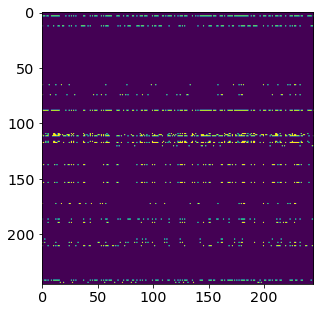

In [42]:
plt.imshow(matrix)

In [43]:
#%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [44]:
class EncoderLinear(keras.layers.Layer):
    def __init__(self, rgm, input_dim=32, units=32):
        super(EncoderLinear, self).__init__()
        self.rgm = rgm
        
        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.convert_to_tensor(self.rgm, dtype=dtype)

            return w_init
        

        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        return tf.matmul(X, tf.multiply(self.rgm, self.w))
    #tf.matmul(inputs, self.w)

In [45]:
class DecoderLinear(keras.layers.Layer):
    def __init__(self, rgm, input_dim=32, units=32):
        super(DecoderLinear, self).__init__()
        self.rgm = rgm

        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.transpose(tf.convert_to_tensor(self.rgm, dtype=dtype))

            return w_init
    
        
        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        #return tf.matmul(X, tf.multiply((self.rgm), self.w))
        X = tf.matmul(X, tf.multiply(tf.transpose(self.rgm), self.w)) 
        #return tf.matmul(inputs, self.w)
        v = tf.zeros_like(X)
        u = tf.ones_like(X)
        u = tf.math.scalar_mul(-1.0, u)
        
        return tf.where(tf.math.less(X, v), u, X) #where X is less than 0, return -1 
        
        

In [46]:
def encoder(parent_child_biological_association, num_hidden_units=2):
    '''
    Encoder structure
    '''
    '''
    The data is time-series. Therefore, CNN to learn the temporal relationship between 
    the intensities for each gene.
    '''
    en_conv = Conv1D(32, 3, activation = "relu")(parent_child_biological_association) # 6*245
    en_dense = Flatten()(en_conv)
    phenotype = Dense(num_hidden_units)(en_dense)
    return phenotype

def decoder(X, num_protein_gene, time_steps):
    '''
    Decoder structure
    '''
    de_dense = Dense(128)(X)
    de_dense = Reshape((1, 128))(de_dense) #tf.reshape(de_dense, (self.batch_size,1,128))
    de_deconv = Conv1DTranspose(num_protein_gene, time_steps, activation = "relu")(de_dense) #used to be transpose
    #de_deconv = Conv1D(num_protein_gene, time_steps, activation = "relu")(de_dense) 
    # gene_reconstruction = self.decoder_biological_operation(de_deconv)
    return de_deconv

def model(rgm, num_protein_gene, time_steps, num_kinase_regulators, num_hidden_units = 2):
    inp = Input(shape=(time_steps, num_kinase_regulators))
    x = EncoderLinear(rgm, 245, 245)(inp)
    enc = encoder(x, num_hidden_units)
    dec = decoder(enc, num_protein_gene, time_steps)
    out = DecoderLinear(rgm, 245, 245)(dec)

    _model = tf.keras.Model(inputs=inp, outputs=out)

    return _model

In [47]:
regulator_gene_matrix = matrix# np.random.randint(0, 2, size=(245, 245)).astype(np.float32)


In [48]:
enc_dec_Synthetic = model(regulator_gene_matrix, 245, 6, 245) #we can just change the time steps to something higher

In [49]:
enc_dec_Synthetic.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6, 245)]          0         
                                                                 
 encoder_linear_1 (EncoderLi  (None, 6, 245)           60025     
 near)                                                           
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 32)             23552     
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
 dense_3 (Dense)             (None, 128)               384       
                                                           

# Create Super parent matrix. FOR USE LATER!!

In [50]:
from tensorflow.keras import losses

In [51]:
superParent = regulator_gene_matrix.copy()
#print(superParent.shape)

ones = np.ones((245))
parentIndex = []
for i in range(len(regulator_gene_matrix)):
    if (np.isin(regulator_gene_matrix[i], [1])).any():
        #print(i)
        superParent[i] = ones 
        parentIndex.append(i)
parentIndex = np.array(parentIndex)
parentIndex = tf.convert_to_tensor(parentIndex)

def ignore_noParent_MSE(y_true, y_pred): 
    l = tf.keras.losses.MeanSquaredError()
    y_true_pruned = tf.gather(y_true,parentIndex, axis =2)
    #print(y_true_pruned.shape
    y_pred_pruned = tf.gather(y_pred, parentIndex, axis =2)   
    return l(y_true_pruned, y_pred_pruned)

In [52]:
enc_dec_Synthetic.compile(optimizer='adam', loss=ignore_noParent_MSE)

In [53]:
# enc_dec_Synthetic.compile(optimizer='adam',loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True))

# Train on bottom 5 synthetic datasets (all but first experiment)

In [54]:
enc_dec_Synthetic.fit(genes_intensities_normalized[1:],genes_intensities_normalized[1:],epochs=10)

Epoch 1/10
1/1 [==============================] - 18s 18s/step - loss: 1.3161
Epoch 2/10
1/1 [==============================] - 0s 5ms/step - loss: 1.1789
Epoch 3/10
1/1 [==============================] - 0s 5ms/step - loss: 1.1378
Epoch 4/10
1/1 [==============================] - 0s 4ms/step - loss: 1.0991
Epoch 5/10
1/1 [==============================] - 0s 4ms/step - loss: 1.0767
Epoch 6/10
1/1 [==============================] - 0s 4ms/step - loss: 1.0218
Epoch 7/10
1/1 [==============================] - 0s 4ms/step - loss: 0.9846
Epoch 8/10
1/1 [==============================] - 0s 4ms/step - loss: 0.9476
Epoch 9/10
1/1 [==============================] - 0s 4ms/step - loss: 0.9386
Epoch 10/10
1/1 [==============================] - 0s 4ms/step - loss: 0.9109


In [57]:
w = enc_dec_Synthetic.get_weights()

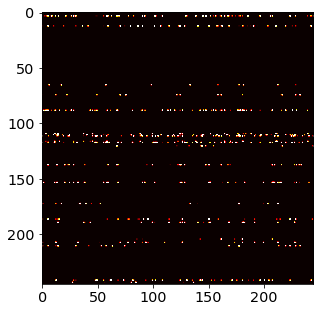

In [58]:
plt.imshow(w[0], cmap = "hot", vmin=0,vmax=0.02)

# The output of the auto encoder trained on synthetic data. Autoencoder has not been trained on synthetic version of experiement 1. We test on the original experiment 1. TODO: test on testset

In [192]:
#we do not need to use this function for the testset
def getCSVs(data_path_head):
    PATH = data_path_head
    EXT = "*.csv"
    all_csv_files = [file
                     for path, subdir, files in os.walk(PATH)
                     for file in glob(os.path.join(path, EXT))]
    actual = []
    for p in all_csv_files:
        actual.append(pd.read_csv(p, index_col = 0).to_numpy())
    return np.array(actual)
    
#testCandidate = getCSVs(data_path_og_exp1)

In [61]:
testCandidate = test

In [62]:
np.array([genes_intensities_normalized[0]]).shape

(1, 6, 245)

In [63]:
testCandidate[0].shape

(6, 245)

In [64]:
np.array([genes_intensities_normalized[0]]).shape

(1, 6, 245)

In [65]:
outSyn = enc_dec_Synthetic.predict(testCandidate)

1/1 [==============================] - 0s 238ms/step


In [68]:
def mymagn(A, B):
    mse = (np.square(A - B)).mean(axis=None)
    return mse

In [69]:
syntheticLoss = ignore_noParent_MSE(outSyn, testCandidate)
syntheticLoss

<tf.Tensor: shape=(), dtype=float64, numpy=483.4611050499836>

In [70]:
(outSyn-testCandidate).shape

(4, 6, 245)

# The autoencoder trained on the interpolated dataset. Once again, we do not train on any version of the original experiment. TODO: test on test set

In [118]:
def read_filesV2(data_path):
    '''
    *Changed*
    currently hardcoded for only one file. 
    change code a bit for reading multiple files.
    '''
    #genes_intensities_data_matrix = pd.read_csv(file_path_intensities, index_col = 0)
    #print(os.listdir(data_path))
    replicate_files = os.listdir(data_path)
    #print('replicate files:',replicate_files)
    replicates = []
    # i = 0
    for file in replicate_files:
        
        #print('file name:',file)
        #print('value of i:',i)
        genes_intensities_data_matrix = pd.read_csv(os.path.join(data_path , file), index_col = 0, on_bad_lines='skip')
        #print('genes_intensities_data_matrix:',  genes_intensities_data_matrix.head())
        replicates.append(genes_intensities_data_matrix.values)
        # i+=1
        
    genes_intensities_data_matrix = genes_intensities_data_matrix.values
    rgm = np.loadtxt(matrix_path)
    
    return np.asarray(replicates), rgm.astype(np.float32)

In [119]:
interpolated_genes, _ = read_filesV2(data_path_inter)

C:\Users\Fin Amin\AppData\Local\Temp\ipykernel_14556\3349346019.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(replicates), rgm.astype(np.float32)


In [120]:
interpolated_genes.shape

(5,)

In [121]:
pd.DataFrame(interpolated_genes[2]).head(5)

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,0.254943,-1.000000,0.663585,0.440312,-1.000000,0.635664,0.734571,-1.000000,0.312044,0.602692,...,-1.000000,0.400712,-1.000000,0.523033,-1.000000,0.561590,0.403879,0.642049,-1.000000,0.443478
1,0.338509,-1.000000,0.612395,0.655007,-1.000000,-1.000000,0.590564,-1.000000,0.353872,0.539972,...,-1.000000,0.445519,-1.000000,0.586067,-1.000000,0.541903,0.426403,0.495559,0.550973,0.419991
2,-1.000000,0.544463,0.596307,0.596367,-1.000000,0.629406,0.579586,0.726602,-1.000000,0.535278,...,0.509166,-1.000000,-1.000000,0.642262,-1.000000,0.586480,0.569283,-1.000000,0.596188,-1.000000
3,-0.329754,-0.454583,-0.828393,0.582746,-0.689224,0.178233,0.309607,-0.297329,-0.461788,0.493608,...,-0.024981,-0.697509,-0.153204,0.546957,0.161868,0.291320,-0.109625,-0.444279,0.007077,-0.254379
4,-1.000000,0.528085,-1.000000,0.523557,-1.000000,0.588043,0.580612,-1.000000,0.354997,0.567674,...,0.573489,0.392001,-1.000000,0.602732,-1.000000,0.544163,0.423905,-1.000000,0.578650,-1.000000


In [122]:
inter = []
for k in range(len(interpolated_genes)):
    #print(k)
    if k == 2 or k == 3 or k == 4:
        inter.append(np.reshape(interpolated_genes[k], (4,6,245)))
    else: 
        inter.append(np.reshape(interpolated_genes[k], (5,6,245)))
inter = np.vstack(inter)

In [123]:
inter.shape

(22, 6, 245)

In [124]:
genes_intensities_normalized[1:].shape

(5, 6, 245)

In [125]:
enc_dec_inter = model(regulator_gene_matrix, 245, 6, 245) 
enc_dec_inter.compile(optimizer='adam', loss=ignore_noParent_MSE)

In [126]:
enc_dec_inter.fit(inter, inter,epochs=10);

Epoch 1/10
1/1 [==============================] - 1s 565ms/step - loss: 0.9627
Epoch 2/10
1/1 [==============================] - 0s 6ms/step - loss: 0.8050
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 0.7330
Epoch 4/10
1/1 [==============================] - 0s 35ms/step - loss: 0.6961
Epoch 5/10
1/1 [==============================] - 0s 8ms/step - loss: 0.6676
Epoch 6/10
1/1 [==============================] - 0s 6ms/step - loss: 0.6465
Epoch 7/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6334
Epoch 8/10
1/1 [==============================] - 0s 7ms/step - loss: 0.6267
Epoch 9/10
1/1 [==============================] - 0s 19ms/step - loss: 0.6201
Epoch 10/10
1/1 [==============================] - 0s 17ms/step - loss: 0.6148


In [127]:
outInter = enc_dec_inter.predict(testCandidate)
interpolationLoss = ignore_noParent_MSE(outInter, testCandidate)

1/1 [==============================] - 0s 90ms/step


In [128]:
interpolationLoss

<tf.Tensor: shape=(), dtype=float64, numpy=1.0613138531240407>

In [129]:
outInter.shape

(4, 6, 245)

In [130]:
u = enc_dec_inter.history
u

In [131]:
interpolationLoss

<tf.Tensor: shape=(), dtype=float64, numpy=1.0613138531240407>

# We have the comparisons between various outputs:

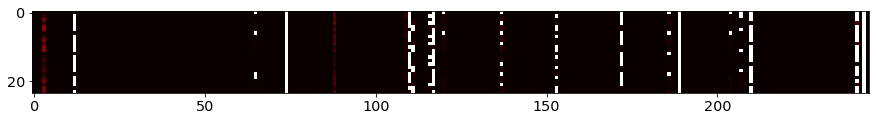

In [132]:
u = plt.imshow(np.reshape((np.abs(outSyn)), (24,245)), cmap = "hot", vmin=0,vmax=1.0 );

In [133]:
u = pd.DataFrame(outSyn[0])
u.head(10)

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,0.0,0.0,0.0,0.010825,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,0.0,-1.0,0.0
1,0.0,0.0,0.0,0.062358,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,0.0,-1.0,0.0
2,0.0,0.0,0.0,0.180853,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,0.0,-1.0,0.0
3,0.0,0.0,0.0,0.066278,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.099643,0.0,-1.0,0.0
4,0.0,0.0,0.0,0.191968,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,0.0,-1.0,0.0
5,0.0,0.0,0.0,0.201126,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.000000,0.0,-1.0,0.0


In [134]:
u = pd.DataFrame(testCandidate[0])
u.head(10)

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,0.545768,0.703299,0.515768,0.311232,0.603906,0.450516,0.485420,-1.000000,0.530434,0.572562,...,-1.000000,-1.000000,-1.000000,-1.000000,0.555532,0.541632,0.654674,0.388019,0.595213,0.494394
1,0.571387,0.671613,0.496906,0.476887,0.518088,0.460362,0.533427,0.339136,0.503110,0.512354,...,-1.000000,0.535256,0.287251,0.287251,0.469841,0.466546,0.570334,0.629295,0.587421,0.491340
2,0.573213,0.659692,-1.000000,0.287767,0.482881,0.573876,0.511186,-1.000000,0.554230,0.491498,...,-1.000000,0.514596,0.319856,0.319856,0.499579,0.408823,0.643895,0.608160,0.558828,0.550060
3,0.719028,0.619979,0.511423,0.440943,0.553337,0.538648,0.516070,-1.000000,0.581957,0.511349,...,0.725449,0.526762,0.378214,0.378214,0.536969,0.488291,0.679073,0.666191,0.593245,0.472189
4,0.754752,0.575484,0.516054,0.478201,0.531809,0.492656,0.538193,-1.000000,0.573013,0.531139,...,0.842432,0.607337,-1.000000,-1.000000,0.542545,0.519905,0.627382,0.668263,-1.000000,-1.000000
5,0.854373,0.601120,0.488601,0.647987,0.477734,0.534696,0.476710,0.424972,0.485754,0.461551,...,0.407374,0.612411,0.309963,0.309963,0.484060,0.585643,0.667441,0.700049,0.564833,0.480564


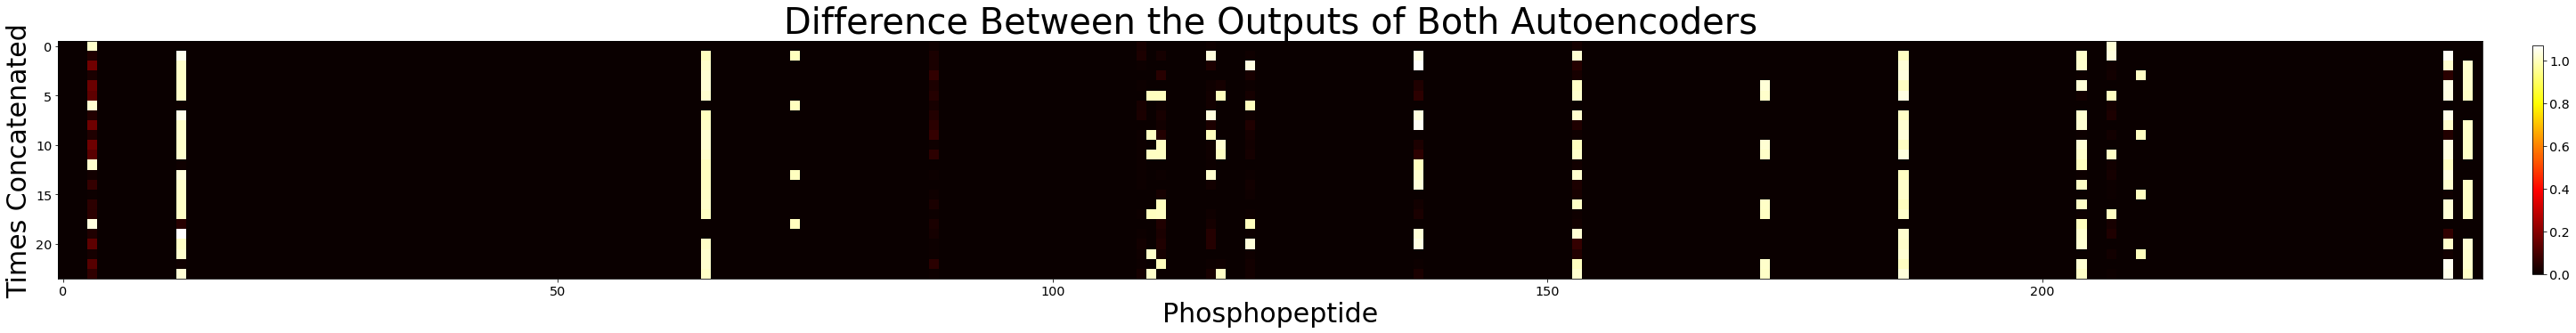

In [135]:
plt.figure(figsize=(50, 50))
u = plt.imshow(np.reshape((np.abs(outSyn-outInter)), (24,245)), cmap = "hot")#, vmin=0,vmax=1.0 );
plt.title("Difference Between the Outputs of Both Autoencoders", fontsize = 40);
plt.xlabel("Phosphopeptide", fontsize = 30);
plt.ylabel("Times Concatenated", fontsize = 30);
plt.colorbar(u ,fraction=0.0046, pad=0.02);
#plt.savefig("DiffBetweenOut.png")

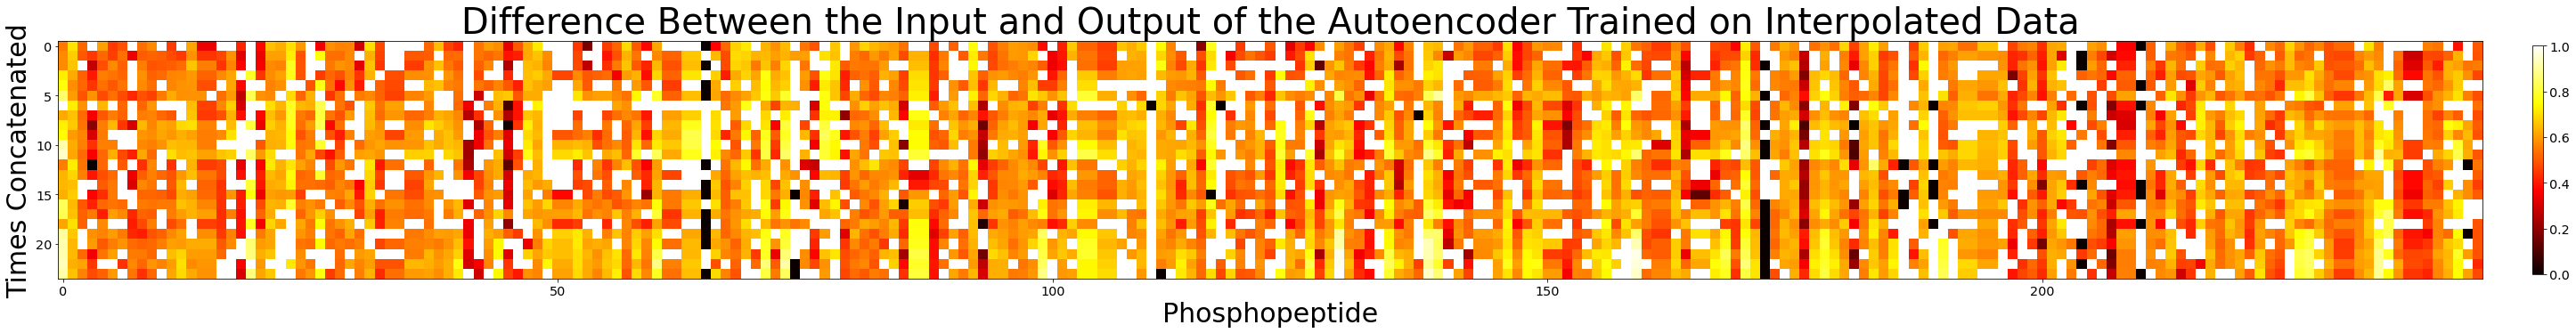

In [136]:
plt.figure(figsize=(50, 50))
u = plt.imshow(np.reshape(np.abs(outInter-testCandidate), (24,245)) , cmap = "hot", vmin=0,vmax=1.0 )
plt.title("Difference Between the Input and Output of the Autoencoder Trained on Interpolated Data", fontsize = 40);
plt.xlabel("Phosphopeptide", fontsize = 30)
plt.ylabel("Times Concatenated", fontsize = 30);
plt.colorbar(u ,fraction=0.0046, pad=0.02)
#plt.savefig("InterDiffImage.png")

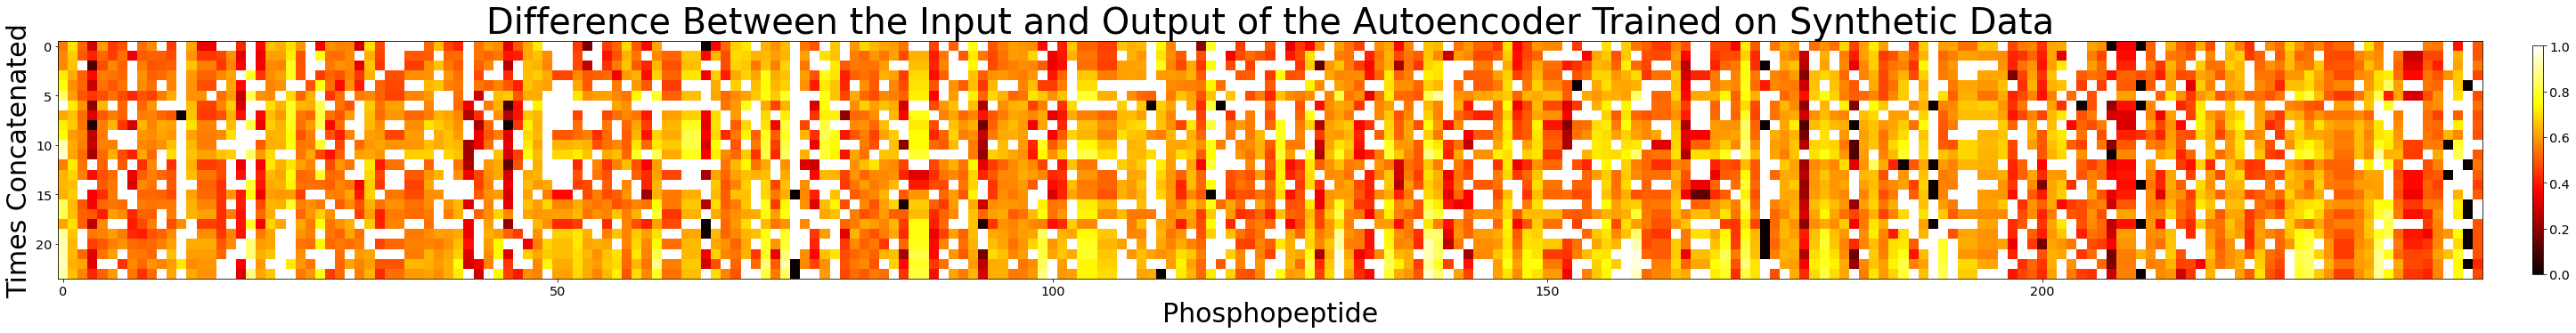

In [137]:
plt.figure(figsize=(50, 50))
u = plt.imshow(np.reshape(np.abs(outSyn-testCandidate), (24,245)), cmap = "hot", vmin=0,vmax=1.0 )
plt.title("Difference Between the Input and Output of the Autoencoder Trained on Synthetic Data", fontsize = 40);
plt.xlabel("Phosphopeptide", fontsize = 30);
plt.ylabel("Times Concatenated", fontsize = 30);
plt.colorbar(u ,fraction=0.0046, pad=0.02);
#plt.savefig("SynDiffImage.png");

In [138]:
u = pd.DataFrame(np.reshape(np.abs(outSyn), (24,245)))
u.head()

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,0.0,0.0,0.0,0.010825,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,1.0,0.0
1,0.0,0.0,0.0,0.062358,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,1.0,0.0
2,0.0,0.0,0.0,0.180853,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,1.0,0.0
3,0.0,0.0,0.0,0.066278,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.099643,0.0,1.0,0.0
4,0.0,0.0,0.0,0.191968,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,1.0,0.0


In [139]:
# np.save("interpolated_.npy", inter) #the interpolated dataset
# np.save("synthetic_.npy", genes_intensities_normalized[1:]) # the synthetic dataset
# np.save("synOut.npy", outSyn) #the output of the encoder trained on synthetic data with the input being exp1
# np.save("interOut.npy", outInter) #the output of the encoder trained on interpolated data with the input being exp1

# Try using a super parent with the synthetic dataset because the synthetic dataset performed the best

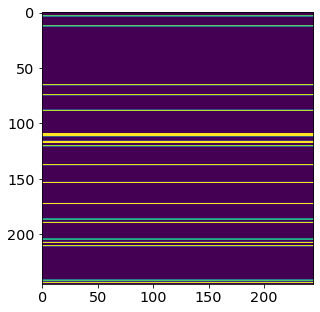

In [141]:
plt.imshow(superParent)

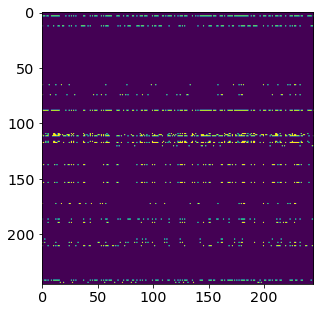

In [142]:
plt.imshow(regulator_gene_matrix)

In [143]:
looseParent = model(superParent, 245, 6, 245, 21)
looseParent.compile(optimizer='adam', loss=ignore_noParent_MSE)
looseParent.fit(inter, inter, epochs=240)

Epoch 1/240
1/1 [==============================] - 1s 544ms/step - loss: 0.8359
Epoch 2/240
1/1 [==============================] - 0s 10ms/step - loss: 0.7095
Epoch 3/240
1/1 [==============================] - 0s 55ms/step - loss: 0.6301
Epoch 4/240
1/1 [==============================] - 0s 97ms/step - loss: 0.5718
Epoch 5/240
1/1 [==============================] - 0s 9ms/step - loss: 0.5497
Epoch 6/240
1/1 [==============================] - 0s 4ms/step - loss: 0.5145
Epoch 7/240
1/1 [==============================] - 0s 4ms/step - loss: 0.4749
Epoch 8/240
1/1 [==============================] - 0s 4ms/step - loss: 0.4496
Epoch 9/240
1/1 [==============================] - 0s 3ms/step - loss: 0.4151
Epoch 10/240
1/1 [==============================] - 0s 4ms/step - loss: 0.3806
Epoch 11/240
1/1 [==============================] - 0s 4ms/step - loss: 0.3598
Epoch 12/240
1/1 [==============================] - 0s 4ms/step - loss: 0.3425
Epoch 13/240
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 3ms/step - loss: 0.1785
Epoch 207/240
1/1 [==============================] - 0s 4ms/step - loss: 0.1785
Epoch 208/240
1/1 [==============================] - 0s 3ms/step - loss: 0.1785
Epoch 209/240
1/1 [==============================] - 0s 3ms/step - loss: 0.1785
Epoch 210/240
1/1 [==============================] - 0s 4ms/step - loss: 0.1785
Epoch 211/240
1/1 [==============================] - 0s 4ms/step - loss: 0.1785
Epoch 212/240
1/1 [==============================] - 0s 4ms/step - loss: 0.1785
Epoch 213/240
1/1 [==============================] - 0s 4ms/step - loss: 0.1785
Epoch 214/240
1/1 [==============================] - 0s 4ms/step - loss: 0.1785
Epoch 215/240
1/1 [==============================] - 0s 3ms/step - loss: 0.1785
Epoch 216/240
1/1 [==============================] - 0s 4ms/step - loss: 0.1785
Epoch 217/240
1/1 [==============================] - 0s 3ms/step - loss: 0.1785
Epoch 218/240
1/1 [==============================] - 0

In [144]:
ignore_noParent_MSE(k := looseParent.predict(testCandidate), testCandidate)

1/1 [==============================] - 0s 90ms/step


<tf.Tensor: shape=(), dtype=float64, numpy=0.7681930698501632>

In [145]:
u = np.reshape(k, (24,245))
u = pd.DataFrame(u)
u.head()

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,0.0,0.0,0.0,0.219408,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.358867,0.0,0.059898,0.0
1,0.0,0.0,0.0,0.386758,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.180966,0.0,0.152100,0.0
2,0.0,0.0,0.0,0.218235,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.074244,0.0,0.138350,0.0
3,0.0,0.0,0.0,0.229954,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.024828,0.0,-1.000000,0.0
4,0.0,0.0,0.0,0.136029,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.018121,0.0,0.070137,0.0


In [146]:
u = np.reshape(testCandidate, (24,245))
u = pd.DataFrame(u)
u.head()

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,0.545768,0.703299,0.515768,0.311232,0.603906,0.450516,0.485420,-1.000000,0.530434,0.572562,...,-1.000000,-1.000000,-1.000000,-1.000000,0.555532,0.541632,0.654674,0.388019,0.595213,0.494394
1,0.571387,0.671613,0.496906,0.476887,0.518088,0.460362,0.533427,0.339136,0.503110,0.512354,...,-1.000000,0.535256,0.287251,0.287251,0.469841,0.466546,0.570334,0.629295,0.587421,0.491340
2,0.573213,0.659692,-1.000000,0.287767,0.482881,0.573876,0.511186,-1.000000,0.554230,0.491498,...,-1.000000,0.514596,0.319856,0.319856,0.499579,0.408823,0.643895,0.608160,0.558828,0.550060
3,0.719028,0.619979,0.511423,0.440943,0.553337,0.538648,0.516070,-1.000000,0.581957,0.511349,...,0.725449,0.526762,0.378214,0.378214,0.536969,0.488291,0.679073,0.666191,0.593245,0.472189
4,0.754752,0.575484,0.516054,0.478201,0.531809,0.492656,0.538193,-1.000000,0.573013,0.531139,...,0.842432,0.607337,-1.000000,-1.000000,0.542545,0.519905,0.627382,0.668263,-1.000000,-1.000000


In [147]:
N = 10
hidden = np.arange(2,33,8) #range(1,32)

lossMatrix = []
for i in tqdm(range(N)):
    
    losses = []
    for value in (hidden):
        looseParent = model(superParent, 245, 6, 245, value)
        looseParent.compile(optimizer='adam', loss=ignore_noParent_MSE)
        looseParent.fit(genes_intensities_normalized, genes_intensities_normalized, epochs=20,  verbose=0)
        test = looseParent(testCandidate) #, verbose = 0)
        loss = ignore_noParent_MSE(test, testCandidate)
        losses.append(loss)
        tf.keras.backend.clear_session()
    lossMatrix.append(losses)
    
lossMatrix = np.array(lossMatrix)
#run 100 times 

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:31<00:00,  3.14s/it]


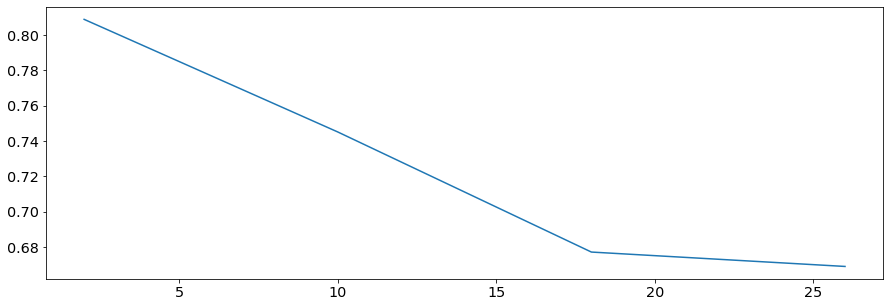

In [149]:
avgMSE = np.average(lossMatrix, axis = 0)
plt.plot(np.arange(2,33,8), avgMSE);

In [ ]:
lossMatrix.shape

In [ ]:
avgMSE = np.average(lossMatrix, axis = 0)

In [ ]:
avgMSE.shape

In [ ]:
#np.save("mse2.npy", avgMSE) #mse2/3 is with -1 fix

In [158]:
'''
a second copy of the layers which will be modified to be a denseNET auto encoder
'''
class EncoderLinear2(keras.layers.Layer):
    def __init__(self, rgm, input_dim=32, units=32):
        super(EncoderLinear2, self).__init__()
        self.rgm = rgm
        
        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.convert_to_tensor(self.rgm, dtype=dtype)

            return w_init
        

        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        return tf.matmul(X, tf.multiply(self.rgm, self.w))
    #tf.matmul(inputs, self.w)

class DecoderLinear2(keras.layers.Layer):
    def __init__(self, rgm, input_dim=32, units=32):
        super(DecoderLinear2, self).__init__()
        self.rgm = rgm

        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.transpose(tf.convert_to_tensor(self.rgm, dtype=dtype))

            return w_init
    
        
        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        #return tf.matmul(X, tf.multiply((self.rgm), self.w))
        return tf.matmul(X, tf.multiply(tf.transpose(self.rgm), self.w)) #used to have a transpose
        #return tf.matmul(inputs, self.w)
        

def encoder2(parent_child_biological_association, inp, num_hidden_units=2):
    '''
    Encoder structure
    '''
    '''
    The data is time-series. Therefore, CNN to learn the temporal relationship between 
    the intensities for each gene.
    '''
    en_conv = Conv1D(490, 3, activation = "tanh")(parent_child_biological_association) # 6*245
    en_dense = Flatten()(en_conv)
    inp = Flatten()(inp)
    #print(en_dense.shape, inp.shape)
    d = Concatenate()([en_dense, inp]) #dense layer
    en_dense = Dense(128)(d) #added a layer
    
    phenotype = Dense(num_hidden_units, activation=)(d)
    return phenotype

def decoder2(X, num_protein_gene, time_steps):
    '''
    Decoder structure
    '''
    de_dense = Dense(128)(X)
    de_dense = Dense(128)(de_dense)#added a layer
    de_dense = Reshape((1, 128))(de_dense) #tf.reshape(de_dense, (self.batch_size,1,128))
    de_deconv = Conv1DTranspose(num_protein_gene, time_steps, activation = "tanh")(de_dense) #used to be transpose
    #de_deconv = Conv1D(num_protein_gene, time_steps, activation = "relu")(de_dense) 
    # gene_reconstruction = self.decoder_biological_operation(de_deconv)
    return de_deconv

def model2(rgm, num_protein_gene, time_steps, num_kinase_regulators, num_hidden_units = 2):
    inp = Input(shape=(time_steps, num_kinase_regulators))
    x = EncoderLinear2(rgm, 245, 245)(inp)
    #x = EncoderLinear2(x)
    enc = encoder2(x, inp, num_hidden_units)
    dec = decoder2(enc, num_protein_gene, time_steps)
    out = DecoderLinear2(rgm, 245, 245)(dec)

    _model = tf.keras.Model(inputs=inp, outputs=out)

    return _model

In [159]:
N = 10
hidden = np.arange(2,33,2) #range(1,32)

lossMatrix = []
for i in tqdm(range(N)):
    
    losses = []
    for value in (hidden):
        looseParent = model2(superParent, 245, 6, 245, value)
        looseParent.compile(optimizer='adam', loss=ignore_noParent_MSE)
        looseParent.fit(genes_intensities_normalized, genes_intensities_normalized, epochs=20,  verbose=0)
        test = looseParent(testCandidate) #, verbose = 0)
        loss = ignore_noParent_MSE(test, testCandidate)
        losses.append(loss)
        tf.keras.backend.clear_session()
    lossMatrix.append(losses)
    
lossMatrix = np.array(lossMatrix)
#run 100 times 

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:14<00:00, 13.48s/it]


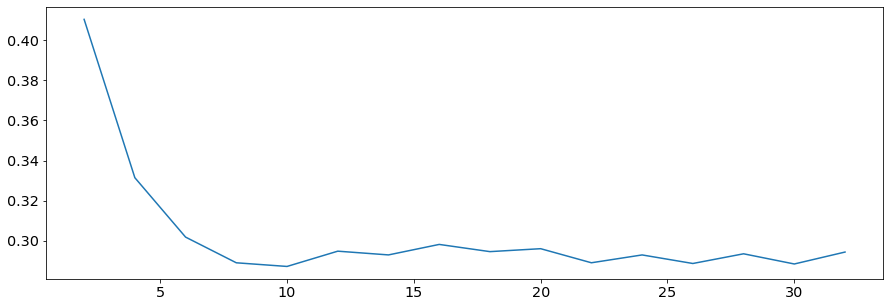

In [162]:
avgMSE = np.average(lossMatrix, axis = 0)
plt.plot(np.arange(2,33,2), avgMSE);

In [ ]:
#np.save("mse3.npy", avgMSE) #mse2/3 is with -1 fix

In [ ]:
#https://www.sciencedirect.com/science/article/pii/S0925231220314570?casa_token=lcEJANqO0JwAAAAA:uL3DGUZctPUZz_sPz1K1i2klMtb83TyKnc9CI3_N-uSOaM7VHL8GhM0jCGYfo25NmpDQQ9Cvlw